# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


## Imports

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Init

In [4]:
import datahandler
import utils


dataset_id = "oslo"

# this is for the OLD pipeline
data_preprocessor = datahandler.DataPreprocessorOUS(dataset_id)
data_preprocessor.execute()

data_loader = datahandler.DataLoader(dataset_id)
data_loader.execute()


Loading dataset: 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


# Plot

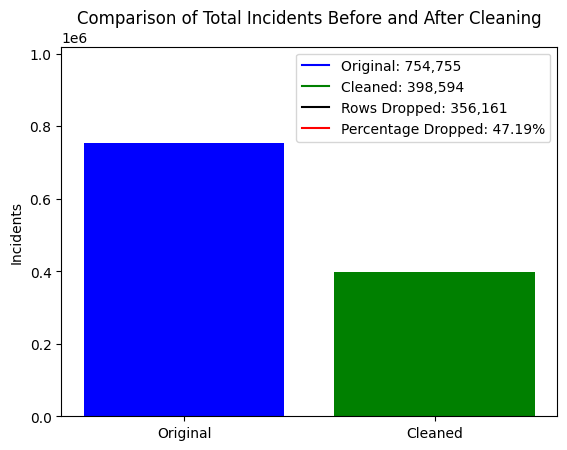

In [5]:
rows_df1 = data_loader.processed_incidents_df.shape[0]
rows_df2 = data_loader.enhanced_incidents_df.shape[0]
rows_dropped = rows_df1 - rows_df2
drop_percentage = (rows_dropped / rows_df1) * 100

labels = ["Original", "Cleaned"]
values = [rows_df1, rows_df2]

fig, ax = plt.subplots()
ax: plt.Axes = ax

bars = ax.bar(labels, values, color=["blue", "green"])
# adjust y-axis limits to provide space for the legend
ax.set_ylim(0, max(values) * 1.35)
# add details to legend
handles, labels = ax.get_legend_handles_labels()
labels.append(f"Original: {rows_df1:,}")
labels.append(f"Cleaned: {rows_df2:,}")
labels.append(f"Rows Dropped: {rows_dropped:,}")
labels.append(f"Percentage Dropped: {drop_percentage:.2f}%")
# assigning specific colors for the legend placeholders
handles.extend([
    plt.Line2D([0], [0], color="blue"),
    plt.Line2D([0], [0], color="green"),
    plt.Line2D([0], [0], color="black"),
    plt.Line2D([0], [0], color="red")
])

ax.legend(handles=handles, labels=labels)

plt.ylabel("Incidents")
plt.title("Comparison of Total Incidents Before and After Cleaning")
plt.show()


In [6]:
df = utils.copy_dataframe(data_loader.processed_incidents_df)
original_count = df.shape[0]

rows_remaining = []
rows_dropped = []
labels = []
# step 0
rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append(f"Original dataset")
# step 1
df.dropna(subset=["time_ambulance_available", "time_ambulance_dispatch_to_scene", "triage_impression_during_call", "time_resource_appointed", "region"], inplace=True)

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append(f"Step 1")
# step 2
mask1 = df["time_ambulance_arrived_at_scene"].isna() & df["time_ambulance_arrived_at_hospital"].notna()
mask2 = df["time_ambulance_dispatch_to_hospital"].isna() & df["time_ambulance_arrived_at_hospital"].notna()
df = df[~(mask1 | mask2)]

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append(f"Step 2")
# step 3
df = df.query('triage_impression_during_call not in ["Moderate Priority", "Scheduled"]').copy()

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append(f"Step 3")
# step 4
df = datahandler.fix_timeframes(df)

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append(f"Step 4")
# step 5
df = datahandler.remove_outliers_pdf(df, 'response_time_sec')

rows_remaining.append(df.shape[0])
rows_dropped.append(original_count - df.shape[0])
labels.append(f"Step 5")

# fix dropped
rows_dropped = rows_dropped[1:]

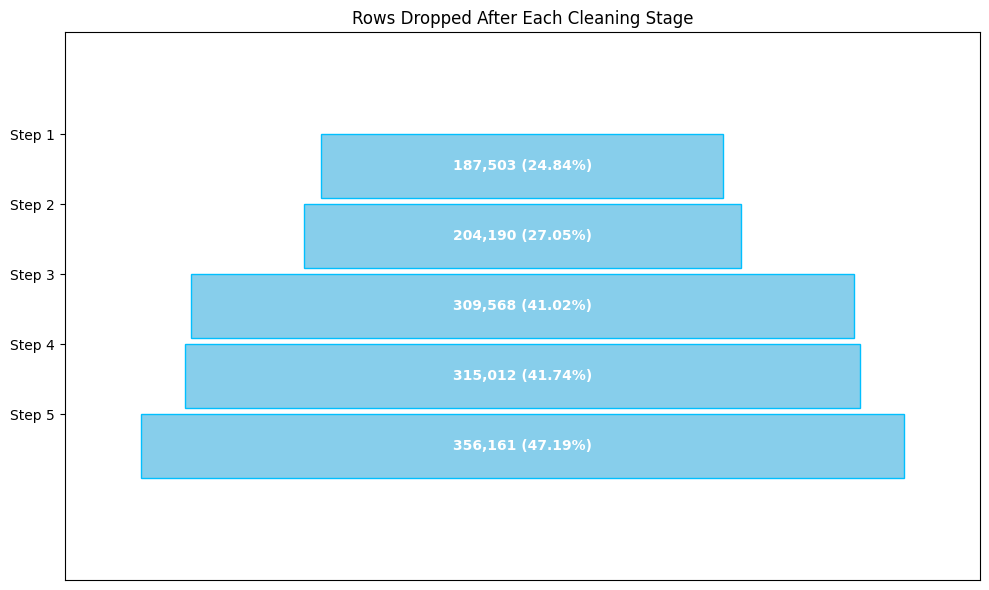

In [7]:
# plot parameters
fig, ax = plt.subplots(figsize=(10, 6))
ax: plt.Axes = ax

bar_height = 0.1
spacing = 0.01
y_val = (len(rows_dropped) - 1) * (bar_height + spacing)
min_width = 200
# loop to plot each bar and annotate it
for i, width in enumerate(rows_dropped):
    adjusted_width = max(width, min_width)
    
    ax.barh(y_val, adjusted_width, left=-adjusted_width/2, color="skyblue", edgecolor="deepskyblue", height=bar_height)
    # calculate percentage of remaining rows
    percentage = (width / original_count) * 100
    ax.text(0, y_val, f"{width:,} ({percentage:.2f}%)", va="center", ha="center", color="white", weight="bold")
    
    y_val -= (bar_height + spacing)
# formatting the plot
ax.set_xlim((-max(rows_dropped + [min_width])/2) * 1.2, (max(rows_dropped + [min_width])/2) * 1.2)
ax.set_ylim(0 - ((bar_height + spacing) + bar_height), len(rows_dropped) * (bar_height + spacing) + bar_height)
ax.set_yticks([(i * (bar_height + spacing)) + (bar_height / 2) for i in range(len(rows_dropped))])
ax.set_yticklabels(labels[1:][::-1])
ax.set_xticks([])
ax.set_title("Rows Dropped After Each Cleaning Stage")

plt.tight_layout()
plt.show()


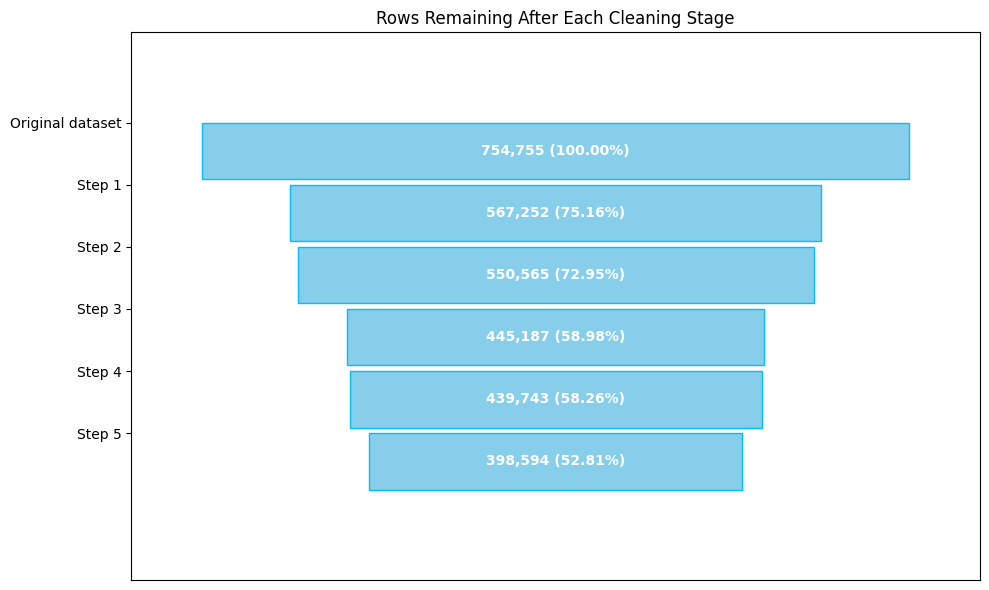

In [8]:
# plot parameters
fig, ax = plt.subplots(figsize=(10, 6))
ax: plt.Axes = ax

bar_height = 0.1
spacing = 0.01
y_val = (len(rows_remaining) - 1) * (bar_height + spacing)
min_width = 200
# loop to plot each bar and annotate it
for i, width in enumerate(rows_remaining):
    adjusted_width = max(width, min_width)
    
    ax.barh(y_val, adjusted_width, left=-adjusted_width/2, color="skyblue", edgecolor="deepskyblue", height=bar_height)
    # calculate percentage of remaining rows
    percentage = (width / original_count) * 100
    ax.text(0, y_val, f"{width:,} ({percentage:.2f}%)", va="center", ha="center", color="white", weight="bold")
    
    y_val -= (bar_height + spacing)
# formatting the plot
ax.set_xlim((-max(rows_remaining + [min_width])/2) * 1.2, (max(rows_remaining + [min_width])/2) * 1.2)
ax.set_ylim(0 - ((bar_height + spacing) + bar_height), len(rows_remaining) * (bar_height + spacing) + bar_height)
ax.set_yticks([(i * (bar_height + spacing)) + (bar_height / 2) for i in range(len(rows_remaining))])
ax.set_yticklabels(labels[::-1])
ax.set_xticks([])
ax.set_title("Rows Remaining After Each Cleaning Stage")

plt.tight_layout()
plt.show()


## Filtering Outliers By Z-Score
https://medium.com/clarusway/z-score-and-how-its-used-to-determine-an-outlier-642110f3b482

Rows removed with PDF filtering: 7850


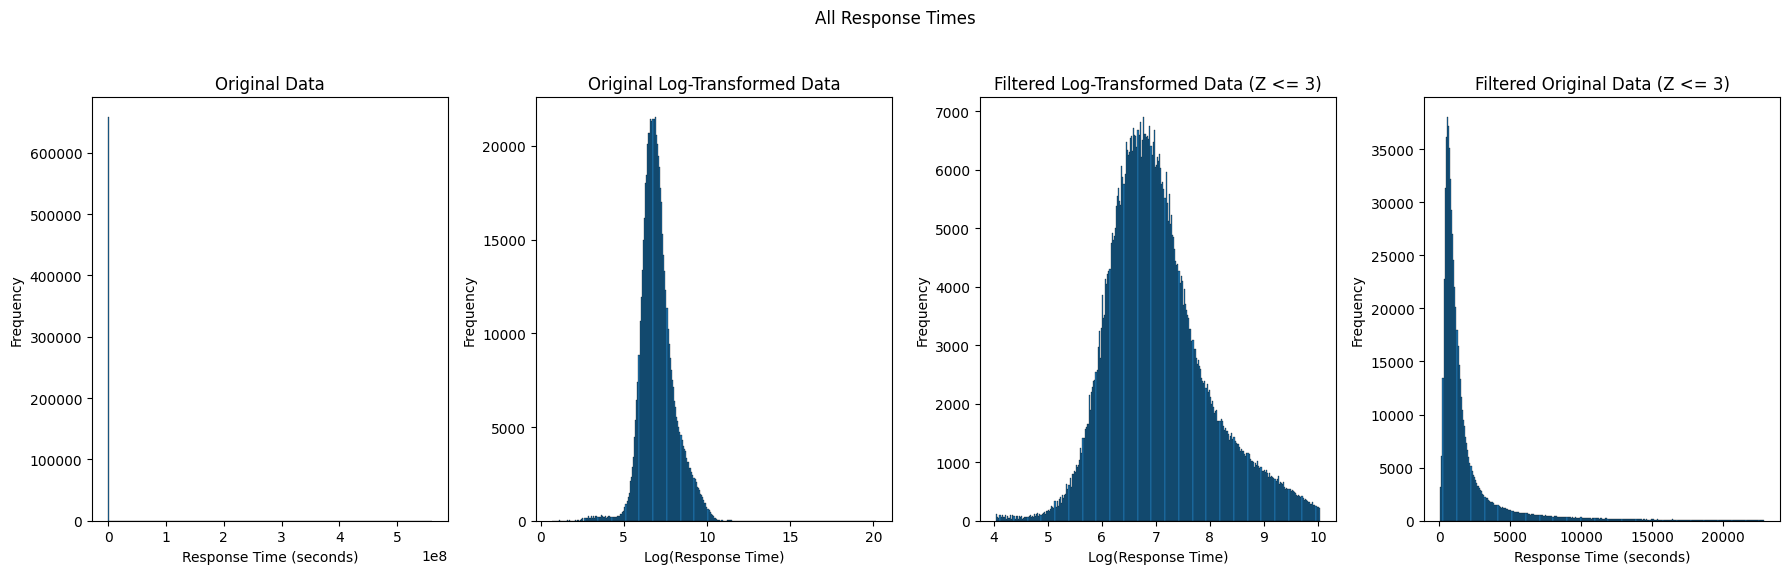

Rows removed with PDF filtering: 5850


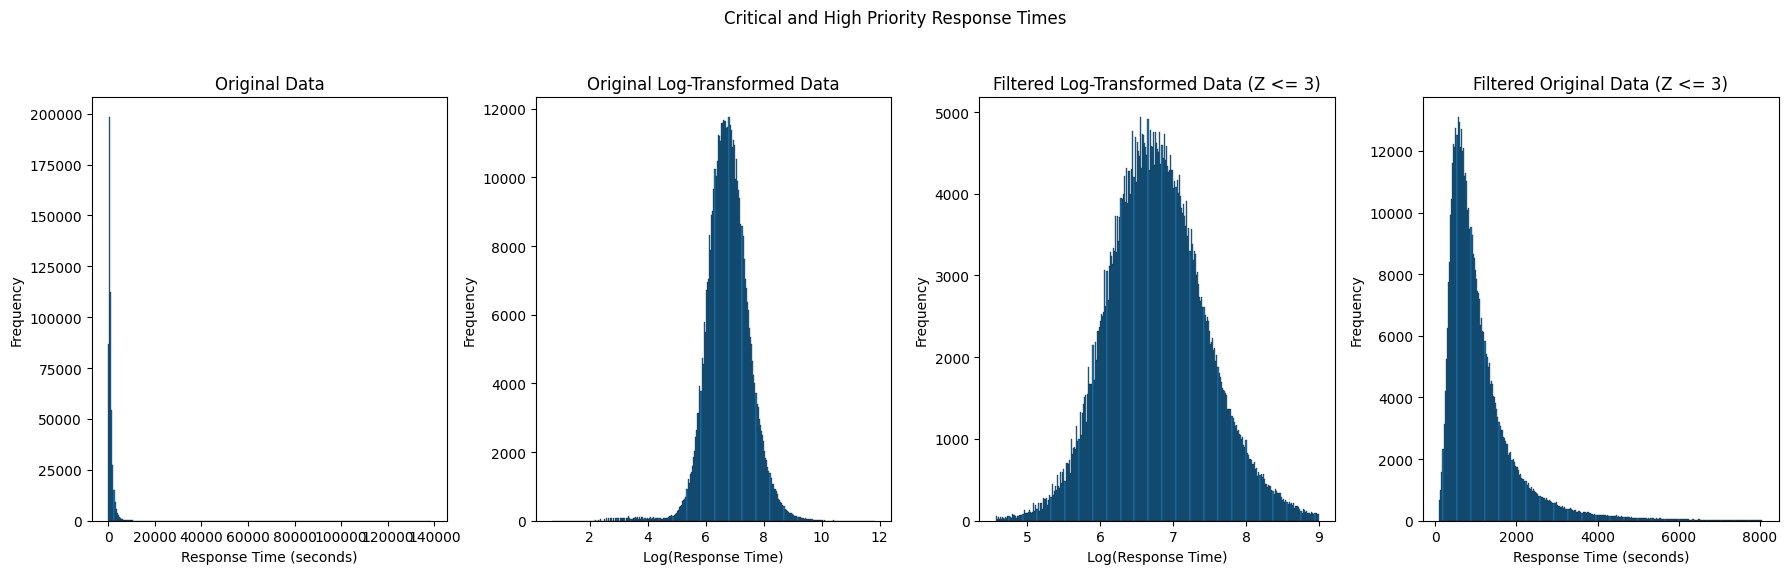

Smallest response time: 94.99999999999999
Smallest response time: 8069.999999999994


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def process_and_plot(df, title):
    # remove negative or zero response times and NaN values
    df = df[df['response_time_sec'] > 0].dropna(subset=['response_time_sec'])
    
    original_count = len(df)
    
    # log transformation
    df_log = np.log1p(df['response_time_sec'])
    
    # calculate mean and standard deviation
    mean_log = np.mean(df_log)
    std_log = np.std(df_log)
    
    # calculate Z-scores and remove outliers
    z_scores_log = (df_log - mean_log) / std_log
    z_score = 3
    df_log_filtered = df_log[np.abs(z_scores_log) <= z_score]
    
    # revert log transformation for the filtered data
    df_filtered = np.expm1(df_log_filtered)
    
    removed_rows = original_count - len(df_filtered)
    print(f"Rows removed with PDF filtering: {removed_rows}")
    
    # plotting
    plt.figure(figsize=(18, 6))
    plt.suptitle(title)
    
    # original data
    plt.subplot(1, 4, 1)
    plt.hist(df['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Original Data')
    
    # original log-transformed data
    plt.subplot(1, 4, 2)
    plt.hist(df_log, bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Log(Response Time)')
    plt.ylabel('Frequency')
    plt.title('Original Log-Transformed Data')
    
    # filtered log-transformed data
    plt.subplot(1, 4, 3)
    plt.hist(df_log_filtered, bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Log(Response Time)')
    plt.ylabel('Frequency')
    plt.title(f'Filtered Log-Transformed Data (Z <= {z_score})')
    
    # filtered original scale data
    plt.subplot(1, 4, 4)
    plt.hist(df_filtered, bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('Frequency')
    plt.title(f'Filtered Original Data (Z <= {z_score})')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return df_filtered


df_processed = data_loader.processed_incidents_df
df_filtered1 = process_and_plot(df_processed, 'All Response Times')

df_high_priority = df_processed[df_processed['triage_impression_during_call'].isin(['Critical', 'High Priority'])]
df_filtered2 = process_and_plot(df_high_priority, 'Critical and High Priority Response Times')

print(f"Smallest response time: {df_filtered2.min()}")
print(f"Smallest response time: {df_filtered2.max()}")


## PDF Filtering

https://www.kaggle.com/code/faressayah/outlier-detection-using-pdf-and-z-score

Rows removed with PDF filtering: 12994


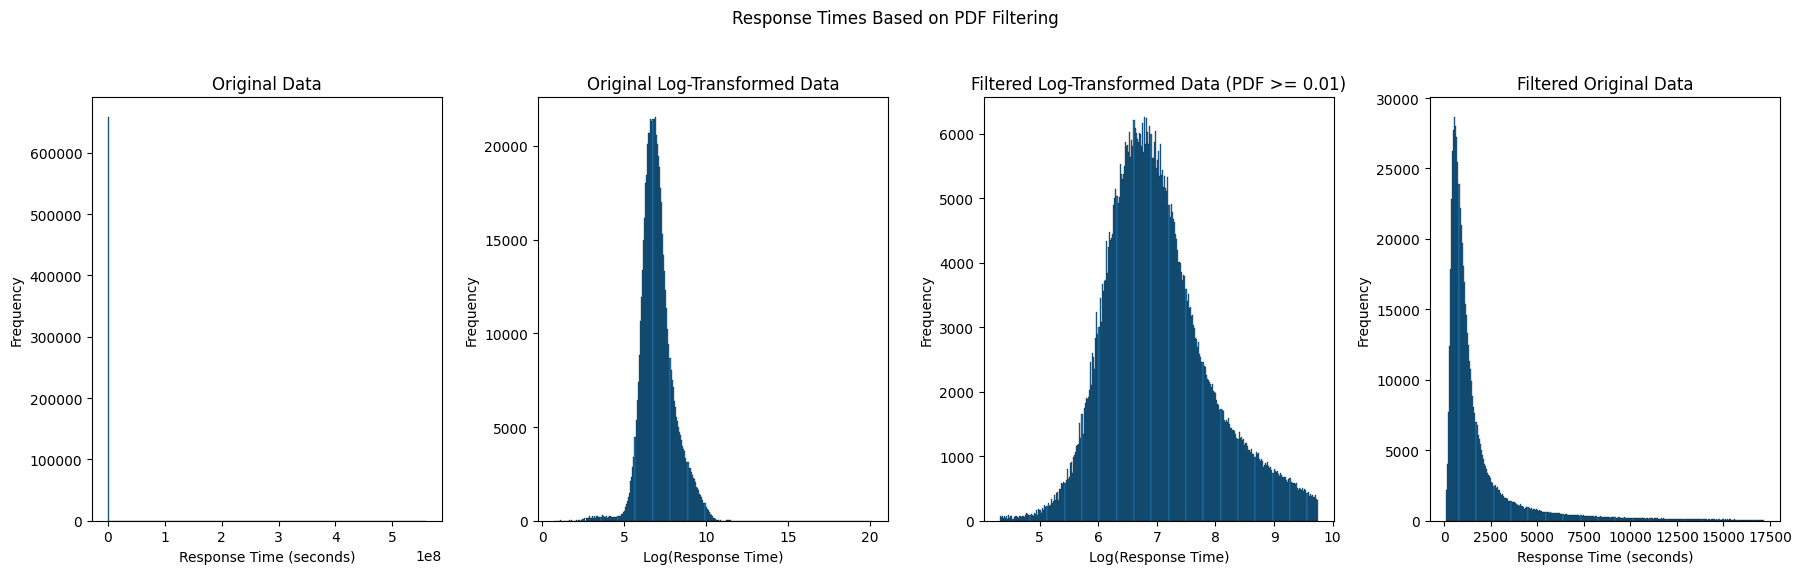

Rows removed with PDF filtering: 6918


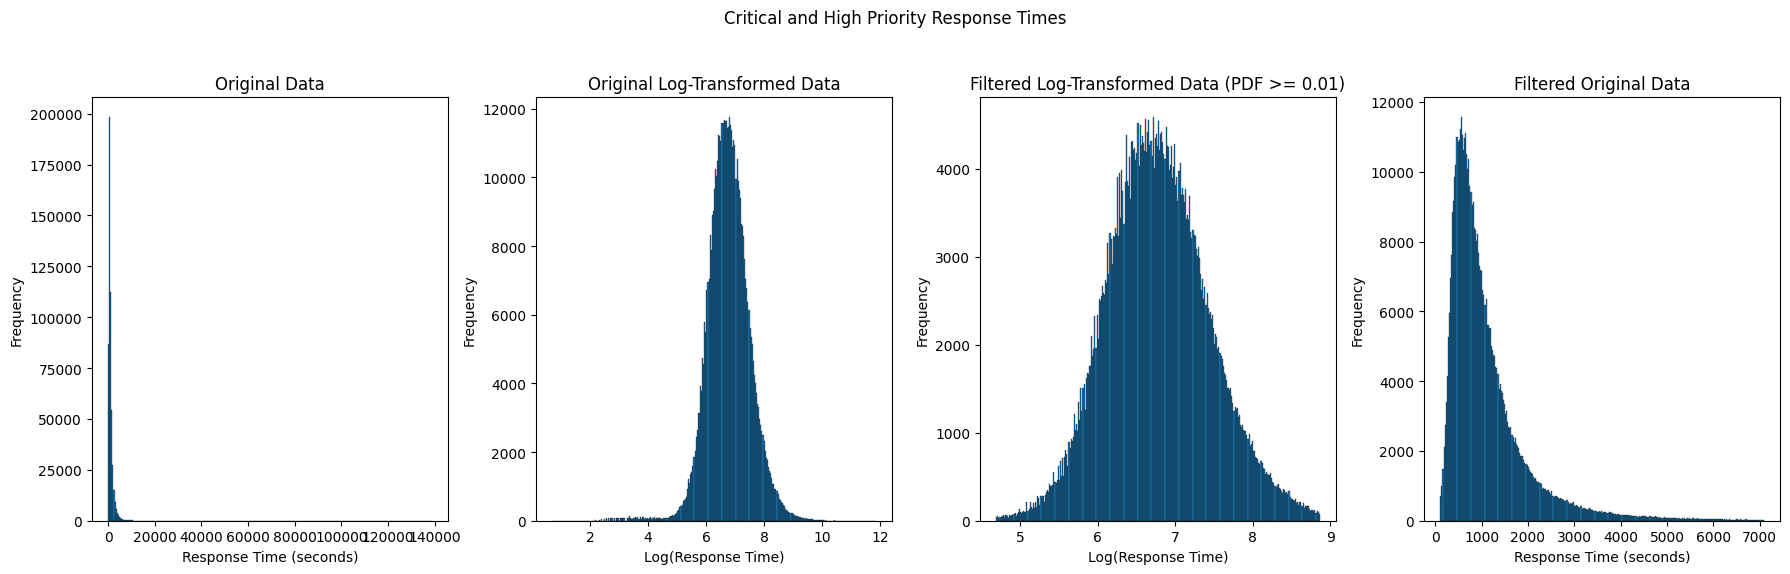

Smallest response time: 107.99999999999997
Smallest response time: 7085.999999999995


In [10]:
from scipy.stats import norm

def process_and_plot_pdf(df, title):
   # remove negative values
    df = df[df['response_time_sec'] > 0].dropna(subset=['response_time_sec'])
    
    original_count = len(df)
    
    #log transform data
    df_log = np.log1p(df['response_time_sec'])
    
    # calculate mean and standard deviation
    mean_log = np.mean(df_log)
    std_log = np.std(df_log)
    
    # calculate PDF values for each data point, set threshold and remove outliers
    pdf_values = norm.pdf(df_log, mean_log, std_log)
    pdf_threshold = 0.01
    df_log_filtered = df_log[pdf_values >= pdf_threshold]
    
    # revert log transformation for the filtered data
    df_filtered = np.expm1(df_log_filtered)
    
    removed_rows = original_count - len(df_filtered)
    print(f"Rows removed with PDF filtering: {removed_rows}")

    # Plotting
    plt.figure(figsize=(18, 6))
    plt.suptitle(title)
    
    # original data
    plt.subplot(1, 4, 1)
    plt.hist(df['response_time_sec'], bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Original Data')
    
    # original log-transformed data
    plt.subplot(1, 4, 2)
    plt.hist(df_log, bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Log(Response Time)')
    plt.ylabel('Frequency')
    plt.title('Original Log-Transformed Data')
    
    # filtered log-transformed data
    plt.subplot(1, 4, 3)
    plt.hist(df_log_filtered, bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Log(Response Time)')
    plt.ylabel('Frequency')
    plt.title(f'Filtered Log-Transformed Data (PDF >= {pdf_threshold})')
    
    # filtered original scale data
    plt.subplot(1, 4, 4)
    plt.hist(df_filtered, bins=300, edgecolor='black', linewidth=0.2)
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('Frequency')
    plt.title('Filtered Original Data')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return df_filtered

df_processed = data_loader.processed_incidents_df
df_high_priority = df_processed[df_processed['triage_impression_during_call'].isin(['Critical', 'High Priority'])]

df_filtered_pdf = process_and_plot_pdf(df_processed, 'Response Times Based on PDF Filtering')
df_filtered_pdf_2 = process_and_plot_pdf(df_high_priority, 'Critical and High Priority Response Times')

print(f"Smallest response time: {df_filtered_pdf_2.min()}")
print(f"Smallest response time: {df_filtered_pdf_2.max()}")

## How many rows have negative response times?

In [11]:
df_processed = data_loader.processed_incidents_df.copy()
print(f"Negative response times: {df_processed[df_processed['response_time_sec'] < 0].shape[0]}")

Negative response times: 7908


## Quantile Representation of Response Times

In [12]:
def generate_quantiles(num_quantiles):
    step = 1 / num_quantiles
    return [round(step * i, 2) for i in range(1, num_quantiles)] + [1.00]

### Five Percent Quantiles

In [13]:
num_quantiles = 20

quantiles = df_processed['response_time_sec'].quantile(generate_quantiles(num_quantiles))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
quantiles

0.05         275.00
0.10         383.00
0.15         459.00
0.20         527.00
0.25         594.00
0.30         662.00
0.35         734.00
0.40         812.00
0.45         898.00
0.50         993.00
0.55        1102.00
0.60        1230.00
0.65        1385.00
0.70        1581.00
0.75        1854.00
0.80        2259.00
0.85        2947.00
0.90        4296.00
0.95        7563.00
1.00   559554300.00
Name: response_time_sec, dtype: float64

### Last Ten Percent in One-Percent Quantiles

In [14]:
num_quantiles = 100

quantiles = df_processed['response_time_sec'].quantile(generate_quantiles(num_quantiles))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
quantiles.tail(10)

0.91        4714.00
0.92        5215.00
0.93        5836.00
0.94        6587.00
0.95        7563.00
0.96        8843.00
0.97       10573.00
0.98       13188.10
0.99       17817.10
1.00   559554300.00
Name: response_time_sec, dtype: float64

## Mean, median and mode for positive time values

In [15]:
stats_dict_good_values = {}

df_sample = data_loader.enhanced_incidents_df

time_columns = [
    'time_call_received', 'time_incident_created', 'time_resource_appointed',
    'time_ambulance_dispatch_to_scene', 'time_ambulance_arrived_at_scene', 'time_ambulance_dispatch_to_hospital',
    'time_ambulance_arrived_at_hospital', 'time_ambulance_available'
]
df_sample[time_columns] = df_sample[time_columns].apply(pd.to_datetime, errors='coerce', format="%Y.%m.%dT%H:%M:%S")
        
# loop through the columns and compare
for i in range(len(time_columns) - 1):
    col1 = time_columns[i]
    col2 = time_columns[i + 1]
    filtered_df_good = df_sample[df_sample[col1] <= df_sample[col2]]
    
    if not filtered_df_good.empty:
        # calculate the time difference in seconds
        time_diff_series_good = (filtered_df_good[col2] - filtered_df_good[col1]).dt.total_seconds()
        
        # calculate mean, median, and mode
        mean_time_diff_good = time_diff_series_good.mean()
        median_time_diff_good = time_diff_series_good.median()
        mode_time_diff_good = time_diff_series_good.mode()[0]  # taking the first mode

        # store the statistics in the dictionary
        stats_dict_good_values[f"{col1} <= {col2}"] = {
            'mean': mean_time_diff_good,
            'median': median_time_diff_good,
            'mode': mode_time_diff_good
        }

# display the statistics for "good" datetime values
stats_dict_good_values

{'time_call_received <= time_incident_created': {'mean': 242.1460960275368,
  'median': 109.0,
  'mode': 47.0},
 'time_incident_created <= time_resource_appointed': {'mean': 227.5961379248057,
  'median': 58.0,
  'mode': 4.0},
 'time_resource_appointed <= time_ambulance_dispatch_to_scene': {'mean': 77.86478220946627,
  'median': 67.0,
  'mode': 4.0},
 'time_ambulance_dispatch_to_scene <= time_ambulance_arrived_at_scene': {'mean': 542.9200339192261,
  'median': 458.0,
  'mode': 2.0},
 'time_ambulance_arrived_at_scene <= time_ambulance_dispatch_to_hospital': {'mean': 1294.5418160340857,
  'median': 1157.0,
  'mode': 2.0},
 'time_ambulance_dispatch_to_hospital <= time_ambulance_arrived_at_hospital': {'mean': 908.0583207512548,
  'median': 760.0,
  'mode': 2.0},
 'time_ambulance_arrived_at_hospital <= time_ambulance_available': {'mean': 1788.562623339246,
  'median': 906.0,
  'mode': 2.0}}